In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit, test_correlation, sensitivity_on_bin

# Inputs

external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"


In [48]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_q_all'] =  (df.filter(regex='_cor_std|q_lvl_[0-6]_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_q_ratio'] =  ((df.filter(regex='_cor_std').sum(axis=1)/(df.filter(regex='q_lvl_[0-6]_std|_cor_std').sum(axis=1)))/df['Entries|2016_Physics']).fillna(0)
df['std_q_ratio_edit'] =  ((df.filter(regex='_cor_std').sum(axis=1)/(df.filter(regex='q_lvl_[0-6]_std|_cor_std').sum(axis=1)))).fillna(0)
df['std_other'] =  (df.filter(regex='view_concept_std|play_video_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0)

# Teacher activity
df['tch_q_cor'] =  (df.filter(regex='_cor_tch').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['tch_q_all'] =  (df.filter(regex='_cor_tch|q_lvl_[0-6]_tch').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['tch_q_ratio'] =  (df.filter(regex='_cor_tch').sum(axis=1)/(df.filter(regex='q_lvl_[0-6]_tch').sum(axis=1))/df['Entries|2016_Physics']).fillna(0)
df['tch_ratio'] =  (df['user_id_tch']/df['Entries|2016_Physics']).fillna(0)
df['tch_other'] = (df.filter(regex='view_assig_prog|create_group|add_assig|ad_custom_assig').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

# Remove unneeded clickstream data
df = df.drop(df.filter(regex='_tch|_std').columns,axis=1)
df = df.drop(['view_assig_prog','add_custom_assig','add_assig','create_group','add_user'],axis=1)

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Set all external indices with no value as NULL
df['IDACI'] = df['IDACI'].replace(to_replace=0,value=np.nan)
df['L_M_index'] = df['L_M_index'].replace(to_replace=0,value=np.nan)
df['Effectiveness'] = df['Effectiveness'].replace(to_replace=0,value=np.nan)
df['Teach_quality'] = df['Teach_quality'].replace(to_replace=0,value=np.nan)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

df.head(5)


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,exam_improv_2013-2014_Biology,exam_improv_2013-2014_Mathematics,exam_improv_2013-2014_Chemistry,exam_improv_2013-2014_Physics,exam_improv_2013-2016_Biology,...,std_q_all,std_q_ratio,std_q_ratio_edit,std_other,std_ratio,tch_q_cor,tch_q_all,tch_q_ratio,tch_ratio,tch_other
URN,,,,,,,,,,,,,,,,,,,,,
100001,NaN,NaN,NaN,NaN,0.0,0.036272,-0.003697,-0.061495,-0.099692,0.029736,...,30.550000,0.026678,0.533552,3.350000,0.200000,0.000000,0.050000,0.000000,0.050000,0.000000
100003,NaN,NaN,NaN,NaN,0.0,-0.080350,-0.020661,-0.019674,0.052747,-0.020112,...,147.677419,0.015897,0.492792,7.193548,0.548387,1.451613,3.516129,0.022681,0.096774,1.322581
100054,5.0,1.0,1.0,1.0,19.7,0.138762,-0.006687,0.016362,0.015041,-0.035131,...,53.948718,0.008226,0.320817,11.871795,0.435897,0.102564,0.333333,0.011396,0.051282,0.358974
100065,NaN,NaN,NaN,NaN,0.0,0.096233,0.001924,0.015242,0.059983,0.064762,...,201.628571,0.010219,0.357659,15.028571,1.057143,4.114286,11.600000,0.015703,0.142857,2.028571
100076,NaN,NaN,NaN,NaN,0.0,-0.107807,0.032783,-0.044749,-0.167057,-0.109535,...,3.500000,0.034985,0.489796,0.142857,0.071429,9.571429,30.000000,0.033467,0.071429,0.000000


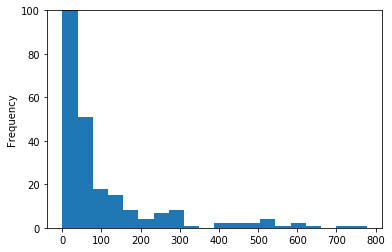

In [27]:
# Determining the histogram of immersion

#df[df['std_ratio']<3]['std_ratio'].plot.hist(bins=20,ylim=(0,100))

df[df['std_q_cor'] < 1000]['std_q_cor'].plot.hist(bins=20,ylim=(0,100))



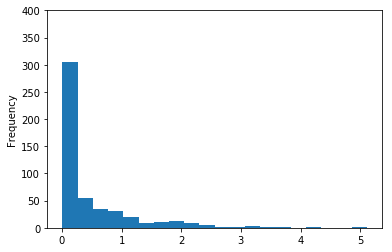

In [41]:
df[df['std_ratio']>0]['std_ratio'].plot.hist(bins=20,ylim=(0,400))

(0.1, 0.7)

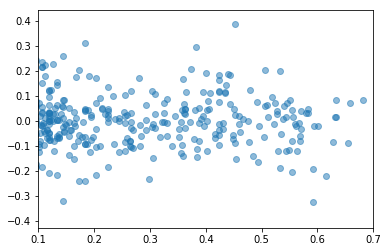

In [56]:
plt.scatter(np.log(1+df['std_ratio']),df['exam_improv_2013-2016_Physics'],alpha=0.5)
plt.xlim([0.1,0.7])

,Coef,R^2,X,Y,intercept
0,0.028117,0.003385,std_ratio,exam_improv_2013-2016_Physics,-0.014609
1,-0.004477,0.000134,std_ratio,exam_improv_2013-2016_Biology,0.000290


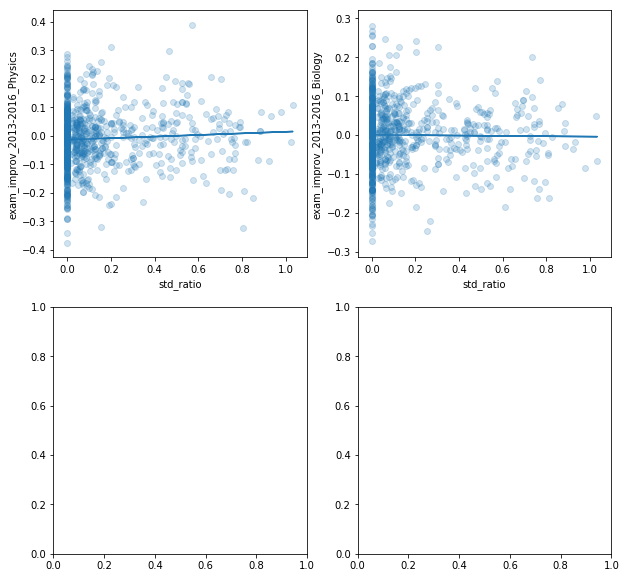

In [50]:
df['std_ratio'] = np.log(df['std_ratio']+1)
checkLinearFit(df,['std_ratio'],['exam_improv_2013-2016_Physics','exam_improv_2013-2016_Biology'])